# OCR model for reading Captchas

**Author:** [A_K_Nain](https://twitter.com/A_K_Nain)<br>
**Date created:** 2020/06/14<br>
**Last modified:** 2020/06/26<br>
**Description:** How to implement an OCR model using CNNs, RNNs and CTC loss.

## Introduction

This example demonstrates a simple OCR model built with the Functional API. Apart from
combining CNN and RNN, it also illustrates how you can instantiate a new layer
and use it as an "Endpoint layer" for implementing CTC loss. For a detailed
guide to layer subclassing, please check out
[this page](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)
in the developer guides.

## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
tf.executing_eagerly()

True

## Load the data: [Captcha Images](https://www.kaggle.com/fournierp/captcha-version-2-images)
Let's download the data.

In [4]:
!unzip -qq images_10k.zip

In [5]:
substitutions = {
    'B': '8',
    'F': 'P',
    'U': 'V',
    '5': 'S',
    '6': 'G',
    'Z': '2',
    'O': '0'
}

def apply_substitutions(input_string):
    output_string = ""
    for char in input_string:
        if char in substitutions:
            output_string += substitutions[char]
        else:
            output_string += char

    return output_string

data_dir = Path("./images_10k/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [apply_substitutions(img.split(os.path.sep)[-1].split(".png")[0]) for img in images]

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
labels = [x + ' ' * (max_length - len(x)) for x in labels]

characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 300
img_height = 80

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

Number of images found:  10780
Number of labels found:  10780
Number of unique characters:  21
Characters present:  [' ', '0', '2', '4', '8', 'A', 'D', 'G', 'H', 'J', 'K', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']


## Preprocessing

In [6]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None,
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.75, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

## Create `Dataset` objects

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualize the data

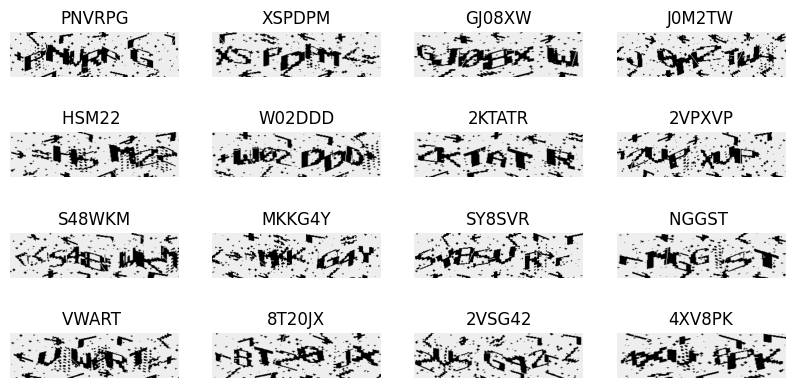

In [8]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(batch_size):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray",  vmin=0, vmax=255)
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Model

In [9]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 300, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 300, 80, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 150, 40, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 150, 40, 64)  18496       ['pool1[0][0]']       

## Training

In [10]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
506/506 [==============================] - 47s 56ms/step - loss: 20.3903 - val_loss: 19.6792
Epoch 2/100
506/506 [==============================] - 26s 51ms/step - loss: 19.5811 - val_loss: 19.5427
Epoch 3/100
506/506 [==============================] - 26s 51ms/step - loss: 19.3835 - val_loss: 19.3300
Epoch 4/100
506/506 [==============================] - 26s 52ms/step - loss: 19.1879 - val_loss: 19.1312
Epoch 5/100
506/506 [==============================] - 27s 53ms/step - loss: 19.0987 - val_loss: 19.0328
Epoch 6/100
506/506 [==============================] - 27s 54ms/step - loss: 19.0443 - val_loss: 19.0023
Epoch 7/100
506/506 [==============================] - 26s 52ms/step - loss: 19.0237 - val_loss: 18.9892
Epoch 8/100
506/506 [==============================] - 26s 52ms/step - loss: 19.0134 - val_loss: 18.9844
Epoch 9/100
506/506 [==============================] - 27s 53ms/step - loss: 19.0469 - val_loss: 19.0271
Epoch 10/100
506/506 [==============================] -

## Inference

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/ocr-for-captcha)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/ocr-for-captcha).

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 300, 80, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 300, 80, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 150, 40, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 150, 40, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 75, 20, 64)        0         
                                                                 
 reshape (Reshape)           (None, 75, 1280)          0         
                                                                 
 dense1 (Dense)              (None, 75, 64)            81984 

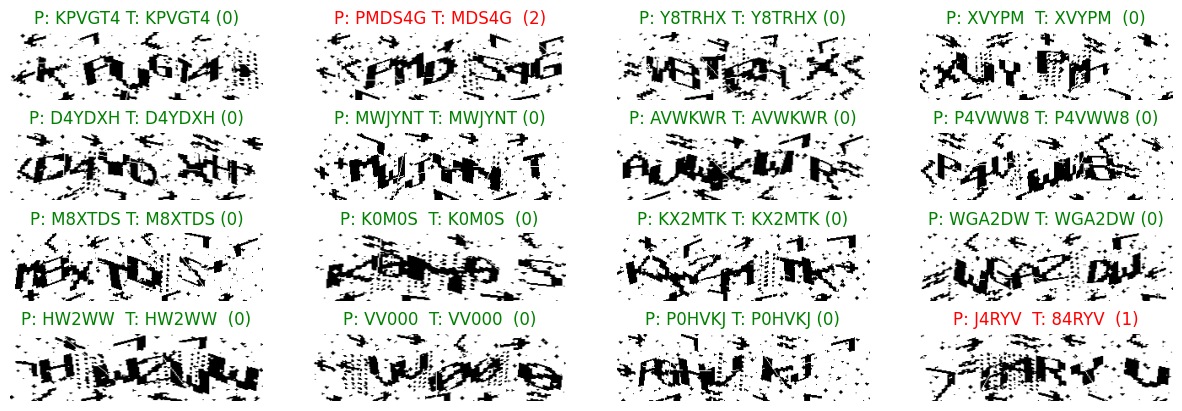

In [11]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

def lev(s1, s2):
    m, n = len(s1), len(s2)
    dp = np.zeros((m + 1, n + 1), dtype=int)

    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0:
                dp[i][j] = j
            elif j == 0:
                dp[i][j] = i
            elif s1[i - 1] == s2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])

    return dp[m][n]
#  Let's check results on some validation samples
_, ax = plt.subplots(4, 4, figsize=(15, 5))

for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        #print(tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T

        pred = pred_texts[i].replace('[UNK]', '')
        comp = orig_texts[i];
        if len(comp) == 5:
            comp += ' '
        if len(pred) == 5:
            pred += ' '

        dist = lev(pred, comp)
        #print([pred, comp])
        title = f"P: {pred} T: {comp} ({dist})"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title, color=('green' if comp in pred else 'red'))
        ax[i // 4, i % 4].axis("off")

plt.show()

In [12]:
solved = []
for batch in validation_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T

        pred = pred_texts[i].replace('[UNK]', '')
        comp = orig_texts[i];

        solved.append(comp == pred)

1/1 [==============================] - 0s 25ms/step


In [13]:
print(f'Solved {solved.count(True)}/{len(solved)} ({100 * (sum(solved) / len(solved)):.04f}%)')

Solved 2657/2695 (98.5900%)


In [14]:
model.save('captcha_75_25.h5')
model.save('captcha_75_25.keras')
model.save('captcha_75_25.tf')